In [1]:
import pandas as pd
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [24]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from UKMovementSensing import hsmm

In [4]:
datadir = "/media/sf_VBox_Shared/London/raw/first5/subsets/"
filesdir = os.path.join(datadir, 'datawithstates/')

In [5]:
# Import data with states
filenames = os.listdir(filesdir)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(filesdir,fn))]
datasets = [pd.read_csv(os.path.join(filesdir,fn)) for fn in filenames]
print(len(datasets))

11


In [7]:
#Concatenate all data together for analysis
all_data = pd.concat(datasets)

In [35]:
#Define consistent colormap
# One more than the number of states, so we have a color for 'All'
colormap, cmap = hsmm.get_color_map(all_data.state.nunique()+1)

## Cross table activity - state

Let's compare the states with the known activities. First we have look at how many 5-seconds frame we have for each state/activity, and we sort from largest to smallest

In [10]:
ctab = pd.crosstab(all_data['act_label'], all_data['state'], margins=True).sort_values('All', ascending=False)

In [55]:
print(states[-1])
print(acts[1])
ctab[states[-1]][acts[1]]

All
Sleeping and resting (including sick in bed)


77580

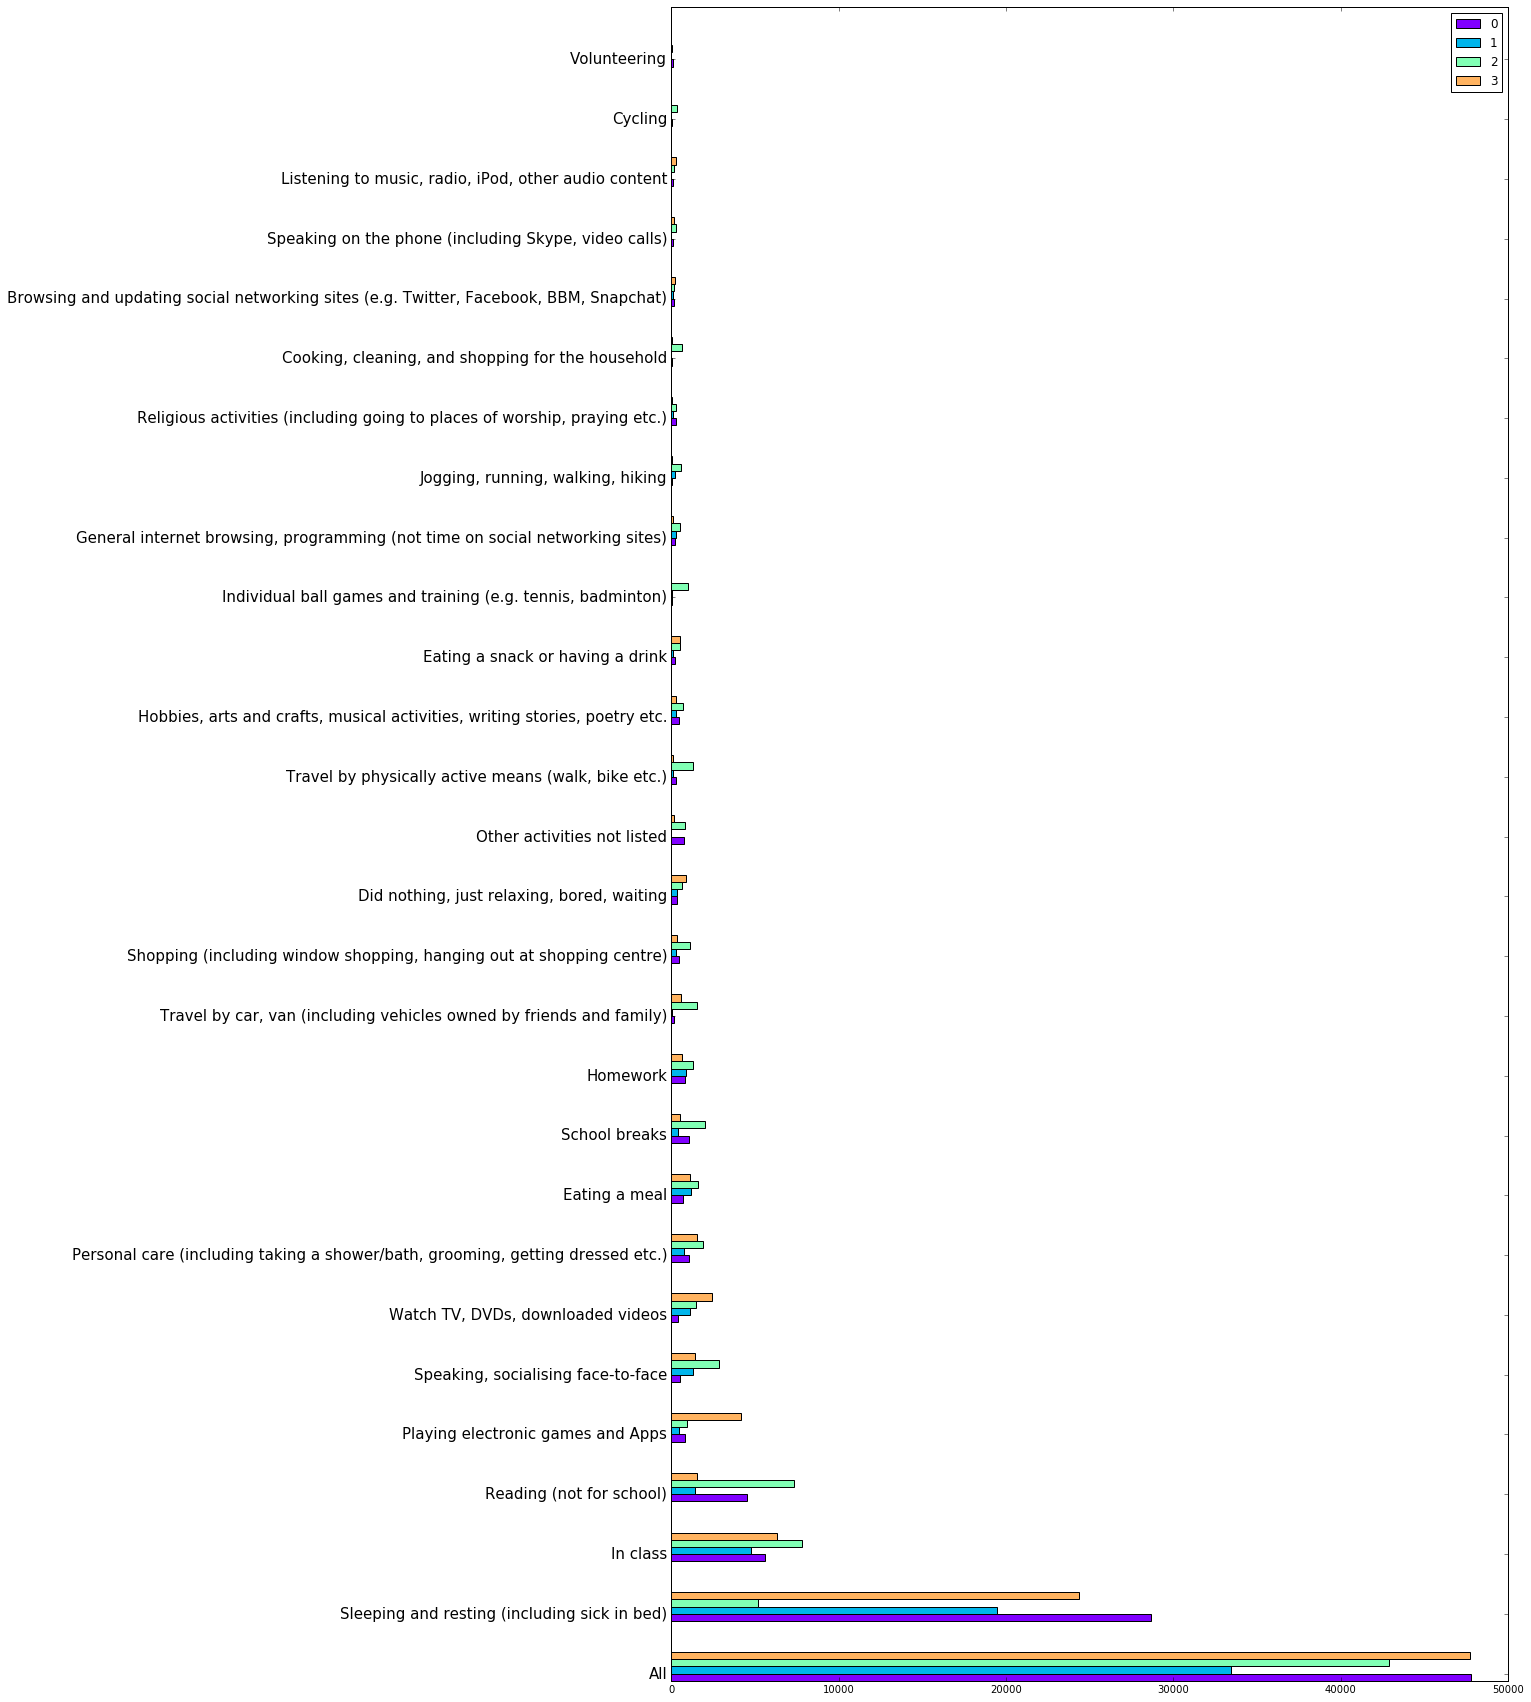

In [61]:
fig, ax = plt.subplots(figsize=(15,30))

states = ctab.columns
acts = ctab.index

n_groups = len(acts)
index = len(states)*np.arange(n_groups)
bar_width = 1./len(states)*3
colors = colormap

#Draw all states, but don't draw All
for i in range(len(states)-1):
    rects1 = plt.barh(index + i*bar_width, 
                     ctab[states[i]], 
                     bar_width,
                     color=colors[i],
                     label=states[i])

plt.yticks(index + bar_width, ctab.index, fontsize=15)
plt.legend()

#Set maximum to something reasonable, namely the maximum of not-all
#ax.set_xlim(0, ctab[states[-1]][acts[1]])
plt.show()

In [75]:
#Now normalize over the activity and sort by total number
ind = list(ctab.index)
ctab_norm1 = pd.crosstab(all_data['act_label'], all_data['state'], normalize='index', margins=True).loc[ind]

In [76]:
ctab_norm1.style.background_gradient(cmap='BuGn',axis=1)

In [87]:
#Now normalize over state and sort by total number
ind = list(ctab.index)
ctab_norm2 = pd.crosstab(all_data['act_label'], all_data['state'], normalize='columns', margins=True).loc[ind]
ctab_norm2 = ctab_norm2.fillna(0)

In [88]:
ctab_norm2.style.background_gradient(cmap='BuGn',axis=0)

## Visualize the states spatially